In [12]:
print("ok")

ok


In [13]:
from langchain_openai import ChatOpenAI

In [14]:
from dotenv import load_dotenv

In [15]:
load_dotenv()

True

In [16]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama-3.3-70b-versatile")

In [17]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [18]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [19]:
openai_model=ChatOpenAI(model="gpt-4o")

In [20]:
llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [ ]:
openai_model.invoke("hi").content

In [22]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [23]:
state={}

In [24]:
state["messages"]=[]

In [25]:
state

{'messages': []}

In [26]:
state["messages"].append("hi")

In [ ]:
state

{'messages': ['hi']}

In [27]:
state["messages"].append("how are you?")

In [28]:
state

{'messages': ['hi', 'how are you?']}

In [29]:
state["messages"].append("what going on?")

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [30]:
state

{'messages': ['hi', 'how are you?', 'what going on?']}

In [31]:
state["messages"][0]

'hi'

In [32]:
state["messages"][-1]

'what going on?'

In [33]:
## this state is a dict which containing the message as list and inside the list there could be n numbvers of messages

## this state will be flowing across all the nodes(function) in langgraph

In [34]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm.invoke(question)
    return {"messages":[response]}

In [35]:
workflow=StateGraph(MessagesState)

In [36]:
workflow.add_node("chatbot",call_model)

In [37]:
workflow.add_edge(START,"chatbot")

In [38]:
workflow.add_edge("chatbot",END)

In [39]:
app=workflow.compile()

In [40]:
from IPython.display import Image,display

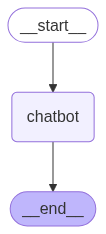

In [41]:
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
input={"messages":["hi my name is Vishwas"]}

In [43]:
response=app.invoke(input)

In [44]:
response["messages"][-1].content

"Hello Vishwas, it's nice to meet you. Is there something I can help you with or would you like to chat?"

In [45]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hello Vishwas, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 41, 'total_tokens': 68, 'completion_time': 0.098181818, 'prompt_time': 0.002006979, 'queue_time': 0.058376641, 'total_time': 0.100188797}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--0e8ebd88-e3fc-4387-8a36-cfcb26490d95-0', usage_metadata={'input_tokens': 41, 'output_tokens': 27, 'total_tokens': 68})]}




In [46]:
@tool
def search(query:str):
    """this is a tool for weather checking"""
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hotty with some foggy"
    return "weather is cloudy with some darkness"

In [47]:
search.invoke("what is a weather in japan?")

'weather is cloudy with some darkness'

In [48]:
search.invoke("what is a weather in delhi?")

'the weather is hotty with some foggy'

In [49]:
tools=[search]

In [50]:
llm_with_tool=llm.bind_tools(tools)

In [51]:
response=llm_with_tool.invoke("hi")

In [52]:
response.content

'<function=search{"query": "hello"}</function>'

In [53]:
response.tool_calls

[]

In [54]:
result=llm_with_tool.invoke("what is a weather in europe?")

In [55]:
result.content

''

In [56]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'europe weather today'},
  'id': 'dq3ckza6f',
  'type': 'tool_call'}]

In [57]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [58]:
input={'messages': ['hi my name is sunny']}

In [59]:
response=call_model(input)

In [60]:
message=response["messages"]

In [61]:
last_message=message[-1]

In [62]:
last_message.content

"Hello Sunny, it's nice to meet you. Is there something I can help you with or would you like to chat?"

In [63]:
last_message.tool_calls

[]

In [64]:
input={'messages': ['what is a weather in mumbai?']}

In [65]:
def router_function(state: MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [66]:
tools

[StructuredTool(name='search', description='this is a tool for weather checking', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C7728D1580>)]

In [67]:
tool_node=ToolNode(tools)

In [68]:
workflow=StateGraph(MessagesState)

In [69]:
workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)

In [70]:
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "myweathertool", END: END})

app = workflow.compile()

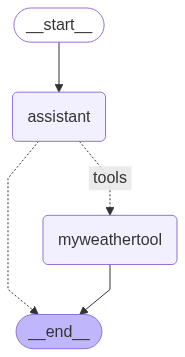

In [71]:
display(Image(app.get_graph().draw_mermaid_png()))

In [72]:
app.invoke({"messages": ["how are you?"]})

{'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='6f97861d-8ccf-4837-bde2-987c1e477cc4'),
  AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. Is there something specific you'd like to know or discuss?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 216, 'total_tokens': 267, 'completion_time': 0.185454545, 'prompt_time': 0.013508638, 'queue_time': 0.056347933, 'total_time': 0.198963183}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'stop', 'logprobs': None}, id='run--80beaf24-124c-4299-8b5a-f270a67ba50c-0', usage_metadata={'input_tokens': 216, 'output_tokens': 51, 'total_tokens': 267})]}

In [73]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='d42c764d-a5c7-48b1-b987-e3acd5a81d7d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'j5fj7d9ta', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 220, 'total_tokens': 235, 'completion_time': 0.054545455, 'prompt_time': 0.013473769, 'queue_time': 0.053227931000000006, 'total_time': 0.068019224}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--59b08244-0ab5-4e23-9e15-34e3769bc005-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather'}, 'id': 'j5fj7d9ta', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 15, 'total_tokens': 235}),
  ToolMessage(content='the weather is hotty with some foggy', name='search

In [74]:
workflow.add_edge("myweathertool","assistant")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [75]:
app = workflow.compile()

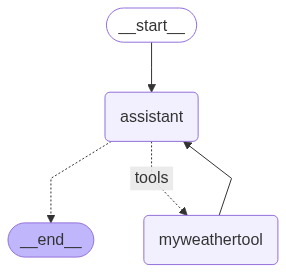

In [76]:
display(Image(app.get_graph().draw_mermaid_png()))

In [77]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='b12ebe6d-ad31-4b75-b2dd-612d7dd9025d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0fd1yxkja', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 220, 'total_tokens': 235, 'completion_time': 0.054545455, 'prompt_time': 0.021200143, 'queue_time': 0.05360323, 'total_time': 0.075745598}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--03cc4954-3127-448a-871b-e0634eff9681-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather'}, 'id': '0fd1yxkja', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 15, 'total_tokens': 235}),
  ToolMessage(content='the weather is hotty with some foggy', name='search', id='0ed

In [80]:
for output in app.stream({"messages": ["what is the weather in delhi"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from assistant
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fc8d4kzv7', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 219, 'total_tokens': 234, 'completion_time': 0.054792974, 'prompt_time': 0.014043944, 'queue_time': 0.052733646999999995, 'total_time': 0.068836918}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6e1a2c0f-a96e-474c-bda8-c40098f73cba-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather'}, 'id': 'fc8d4kzv7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 15, 'total_tokens': 234})]}


here is output from myweathertool
_______
{'messages': [ToolMessage(content='the weather is hotty with some foggy', name='search', id='f29f1c50-ef72-43ed-bf39-819a44b8cb8c', t

In [81]:
@tool
def multiply(a:int,b:int)->int:
    """multiply a and b"""
    return a*b

In [82]:
@tool
def add(a:int,b:int)->int:
    """adding two numbers a and b"""
    return a+b

In [83]:
@tool
def divide(a:int,b:int)->int:
    """dividing two numbers a and b"""
    return a/b

In [84]:
@tool
def subtract(a:int,b:int)->int:
    """subtracting two numbers a and b """
    return a-b

In [85]:
from langchain_community.tools import DuckDuckGoSearchRun


In [86]:
duckduckgo_search=DuckDuckGoSearchRun()

In [87]:
duckduckgo_search.invoke("who is a current prime minister of India??")

"List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. Jawaharlal Nehru is the first and the longest ... Prime Minister Shri Narendra Modi met the members of various delegations who represented India in different countries at his official residence in New Delhi today. ... Shri Narendra Modi was sworn-in as India's Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary elections. ... The prime minister of India (ISO: Bhārata kē Pradhānamantr ... Modi is the current prime minister of India, serving since 26 May 2014 and the first to win three consecutive elections to secure a third successive term, 2014, 2019, 2024. Origins and history. Narendra Modi is the current Prime Minister of India. He represents Varanasi constituency in the Lok Sabha. He is a prominent leader of the Bharatiya Janata Party (BJP). He assumed office as Prime Minister f

In [88]:
tools=[multiply, add, divide, subtract, duckduckgo_search]

In [89]:
llm_with_tools=llm.bind_tools(tools)

In [90]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C76F7154C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C76FCBF710>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'multiply a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'adding two numbers a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'dividing two numbers a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'func

In [91]:
llm_with_tools.invoke("hi").tool_calls

[]

In [92]:
llm_with_tools.invoke("can you add these two number 5 and 40?").tool_calls

[]

In [ ]:
llm_with_tools.invoke("can you multiply these two number 5 and 40?").tool_calls

[{'name': 'multiply',
  'args': {'a': 5, 'b': 40},
  'id': '5js8fbzks',
  'type': 'tool_call'}]

In [93]:
llm_with_tools.invoke("can you divide these two number 5 and 40?").tool_calls

[]

In [94]:
llm_with_tools.invoke("what is a current gdp of india with current affaires").tool_calls

[]

In [95]:
from langchain_core.messages import HumanMessage, SystemMessage

In [96]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
     

In [98]:
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

In [99]:
builder=StateGraph(MessagesState)

In [100]:
builder.add_node("assistant",assistant)

In [101]:
builder.add_node("tools",ToolNode(tools))

In [102]:
builder.add_edge(START,"assistant")

In [103]:

from langgraph.prebuilt import tools_condition

In [104]:
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

In [105]:
react_app=builder.compile()

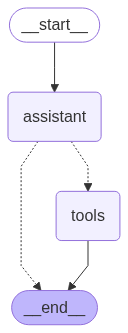

In [106]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [107]:
builder.add_edge("tools","assistant")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [108]:
react_app=builder.compile()

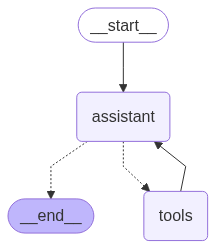

In [109]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [110]:
message=[HumanMessage(content="what is twice of narendra modi's current age?")]

## this below detail is called a agentic flow
# first it will come to assistant
# then it will search narendra modi age
# then it will come to again assistant
# then it wil call the multiply tool for getting twice of age
# then again it will come to assistant 
# then it will generate a final answer

# REACT->> Reasoning+actions

# Thinking, action, observation, thiniking,action, observation---> if everything is going to be full fill
# then generating a final ans

In [111]:
response=react_app.invoke({"messages":message})

In [112]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is twice of narendra modi's current age?
================================== Ai Message ==================================

To find the twice of Narendra Modi's current age, I need to find out his current age first.

<function=duckduckgo_search{"query": "Narendra Modi current age"}</function>


In [113]:
messages=[HumanMessage(content="hi hello how are you?")]

In [114]:
response=react_app.invoke({"messages":messages})

In [115]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi hello how are you?
================================== Ai Message ==================================

I'm doing well, thank you for asking. Is there something I can help you with, like a math problem or a question that you'd like me to search for?


1. humanmessage
2. ai mesage:toolcall
3. duckcuk
4. ai assistant
5. sustract
6. ai
7. final answer

In [116]:
messages=[HumanMessage(content="what is current gdp of china and india can you give me difference between them?")]

In [118]:
response=react_app.invoke({"messages":messages})

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=duckduckgo_search{"query": "current GDP of China and India"}</function>\n<function=duckduckgo_search{"query": "GDP difference between China and India"}</function>'}}

In [119]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi hello how are you?
================================== Ai Message ==================================

I'm doing well, thank you for asking. Is there something I can help you with, like a math problem or a question that you'd like me to search for?


As of 2023, China's GDP is approximately $17.73 trillion, while India's GDP is about $3.9 trillion. The difference in their GDPs is approximately $13.83 trillion, with China's economy being larger than India's by this amount.

In [ ]:
project:rag,agent,deployment,modularcoding,ci/cd,git

multiagentic collrabtive agent and supoervisor agent



Reaserch and analsysis react agent: assisgnment
1. llm assistant
2. take a realtime weather api to check the real time weather detail
3. take a realtime api for checking realtime cricket score
4. take a tool for analysis the generated data(REPL)python code
5. create a report based on the generated data
memory
human in loop
multiagentic flow


from next week onwards will implemnt the project

## 1. langgraph-> memeory saver, human in loop
## 2. multiagents

In [120]:

from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY="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"
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [122]:
import os
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [123]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [124]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults(tavily_api_key="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")
    result=tavily.invoke(query)
    return result
     

In [125]:
search.invoke("who is a current PM in india?")

[{'title': 'Prime Minister of India - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_India',
  'content': 'Narasimha Rao, Atal Bihari Vajpayee, Manmohan Singh, and Narendra Modi. Modi is the current prime minister of India, serving since 26 May 2014 and the first',
  'score': 0.8773195},
 {'title': 'List of all Prime Ministers of India (1947-2025) - Jagran Josh',
  'url': 'https://www.jagranjosh.com/general-knowledge/list-of-all-prime-ministers-of-india-1473165149-1',
  'content': "Currently, Narendra Modi is the Prime Minister of India, having been in office since 2014. He is the 14th Prime Minister of India who had three consecutive terms on the post.\xa0He took the Prime Minister's Oath on June 9, 2024.\n\nThis article provides a complete list of all the Prime Ministers of India from 1947 to 2025, along with their contributions to the country’s growth. The list reflects India's democratic resilience and its leaders' varied contributions to the nation's progres

In [126]:
tools=[search,multiply]

In [127]:
model_with_tools=llm.bind_tools(tools)

In [128]:
model_with_tools.invoke("who is a cuurent pm of japan?")

AIMessage(content='<function=search{"query": "current Prime Minister of Japan"}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 280, 'total_tokens': 297, 'completion_time': 0.061818182, 'prompt_time': 0.017766274, 'queue_time': 0.057116606, 'total_time': 0.079584456}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--563a4c2d-1ca7-4e5d-9c20-7b73b9829e19-0', usage_metadata={'input_tokens': 280, 'output_tokens': 17, 'total_tokens': 297})

In [129]:
model_with_tools.invoke("who is a cuurent pm of japan?").tool_calls

[]

In [130]:
tool_mapping={tool.name: tool for tool in tools}

In [131]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C774333BA0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001C7743327A0>)}

In [132]:
response=model_with_tools.invoke("who is a current president of uk?")

In [134]:
response

AIMessage(content='<function=search{"query": "current president of UK"}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 279, 'total_tokens': 295, 'completion_time': 0.058181818, 'prompt_time': 0.017786548, 'queue_time': 0.053546965, 'total_time': 0.075968366}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--170e4ec1-8963-4383-a81b-5cd8ef3b4cf2-0', usage_metadata={'input_tokens': 279, 'output_tokens': 16, 'total_tokens': 295})

In [135]:
tool_details=response.additional_kwargs

In [136]:
tool_details

{}

In [137]:
tool_details=tool_details.get("tool_calls")

In [138]:
tool_details[0]["function"]["name"]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
tool_details[0]["function"]["arguments"]

'{"query":"current president of uk"}'

In [ ]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'current president of uk'}

In [ ]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'Rishi Sunak | Biography, Wife, Politics, & Net Worth - Britannica',
  'url': 'https://www.britannica.com/biography/Rishi-Sunak',
  'content': '![David Cameron. President Barack Obama and Prime Minister David Cameron of the United Kingdom talk during the G8 Summit at the Lough Erne Resort in Enniskillen, Northern Ireland, June 17, 2013](https://cdn.britannica.com/46/172446-131-3351BF8A/David-Cameron-Barack-Obama-talk-United-Kingdom-June-17-2013.jpg?w=200&h=200&c=crop) [...] As a result of his parents’ sacrifices and saving to fund his education, Sunak was able to attend [Winchester College](https://www.britannica.com/topic/Winchester-College), the [exclusive](https://www.merriam-webster.com/dictionary/exclusive) private school that has produced no fewer than six chancellors of the Exchequer. In addition to becoming “head boy” at Winchester, Sunak was the editor of the school’s newspaper. During summer vacations he waited tables at a Southampton Indian restaurant. [...] In Ma

In [ ]:
tool_mapping={tool.name: tool for tool in tools}

In [ ]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001F265F7FA60>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001F265F7F920>)}

In [139]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

In [140]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [141]:
def invoke_tool(state:AgentState):
    print("****my state*****")
    print(state['messages'][-1])
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        print("**********tool detils****")
        print(tool_details)
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}
     

In [142]:
def router(state:AgentState):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"
     

In [143]:
graph=StateGraph(AgentState)

In [144]:
graph.add_node("ai_assistant",invoke_model)
graph.add_node("tool",invoke_tool)

In [145]:
graph.add_conditional_edges("ai_assistant",
                            router,
                            {"tool":"tool",
                             "end":END})

In [146]:
graph.add_edge("tool", END)

# graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [147]:
app=graph.compile()

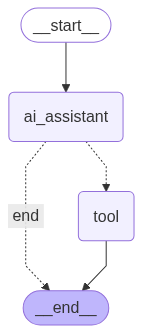

In [148]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [149]:
app.invoke({"messages": ["who is president of India?"]})

{'messages': ['who is president of India?',
  AIMessage(content='<function=search{"query": "President of India"}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 277, 'total_tokens': 292, 'completion_time': 0.054545455, 'prompt_time': 0.018073503, 'queue_time': 0.057900999999999994, 'total_time': 0.072618958}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--54025c07-c1d7-49a0-a87f-3e703c66edb5-0', usage_metadata={'input_tokens': 277, 'output_tokens': 15, 'total_tokens': 292})]}

In [150]:
for s in app.stream({"messages": ["who is president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='<function=search{"query": "current President of the United States"}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 277, 'total_tokens': 295, 'completion_time': 0.081245072, 'prompt_time': 0.018685259, 'queue_time': 0.065205292, 'total_time': 0.099930331}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--1be2778e-1da3-4617-a6d7-bec0e33a9c66-0', usage_metadata={'input_tokens': 277, 'output_tokens': 18, 'total_tokens': 295})]}
----


In [151]:
app.invoke({"messages": ["what is multiplication of 23 and 46?"]})

****my state*****
content='' additional_kwargs={'tool_calls': [{'id': 's5gf5r7ep', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 281, 'total_tokens': 302, 'completion_time': 0.076363636, 'prompt_time': 0.017866281, 'queue_time': 0.056692520999999996, 'total_time': 0.094229917}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--efa58a96-d5ad-4219-b237-f23c9478192e-0' tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 's5gf5r7ep', 'type': 'tool_call'}] usage_metadata={'input_tokens': 281, 'output_tokens': 21, 'total_tokens': 302}
Selected tool: multiply


{'messages': ['what is multiplication of 23 and 46?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's5gf5r7ep', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 281, 'total_tokens': 302, 'completion_time': 0.076363636, 'prompt_time': 0.017866281, 'queue_time': 0.056692520999999996, 'total_time': 0.094229917}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--efa58a96-d5ad-4219-b237-f23c9478192e-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 's5gf5r7ep', 'type': 'tool_call'}], usage_metadata={'input_tokens': 281, 'output_tokens': 21, 'total_tokens': 302}),
  1058]}

In [152]:
app.invoke({"messages": ["Who won the IPL 2025?"]})

{'messages': ['Who won the IPL 2025?',
  AIMessage(content='<function=search{"query": "IPL 2025 winner"}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 279, 'total_tokens': 297, 'completion_time': 0.065454545, 'prompt_time': 0.018019888, 'queue_time': 0.057923713, 'total_time': 0.083474433}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--8f887f8f-0544-499a-a454-03d8df33714f-0', usage_metadata={'input_tokens': 279, 'output_tokens': 18, 'total_tokens': 297})]}

## Langgraph human in loop concept

In [ ]:

tavily=TavilySearchResults()
     

In [ ]:

tools = [tavily]

In [ ]:
llm_with_tools=llm.bind_tools(tools)

In [ ]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
memory=MemorySaver()

In [ ]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [ ]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [ ]:
app2=graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

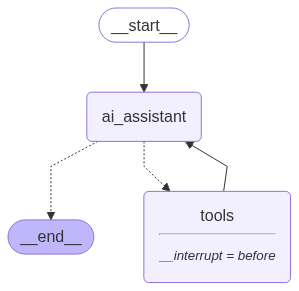

In [ ]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [ ]:
user_input = "what is current a GDP of india?"
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = "what is today value of apple stock?"
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = "famous places of the bangalore and must visit restaurants?"
config = {"configurable": {"thread_id": "1"}}

In [ ]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [ ]:
for event in events:
    print(event)

{'messages': [('user', 'famous places of the bangalore and must visit restaurants?')]}
{'messages': [('user', 'famous places of the bangalore and must visit restaurants?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4ptnz3rns', 'function': {'arguments': '{"query":"famous places in Bangalore and must visit restaurants"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 991, 'total_tokens': 1084, 'completion_time': 0.169090909, 'prompt_time': 0.03499773, 'queue_time': 0.24604857000000002, 'total_time': 0.204088639}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9951d717-6d44-4a8e-8c38-628135b6ccdc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'famous places in Bangalore and must visit restaurants'}, 'id': '4ptnz3rns', 'type': 'tool_call'}], usage_metadata={'input_tokens'

In [ ]:
snapshot=app2.get_state(config)

In [ ]:
snapshot.next

('tools',)

In [ ]:

last_message=snapshot.values["messages"][-1]

In [ ]:

last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'famous places in Bangalore and must visit restaurants'},
  'id': '4ptnz3rns',
  'type': 'tool_call'}]

In [ ]:
events = app2.stream(None, config, stream_mode="values")

In [ ]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (4ptnz3rns)
 Call ID: 4ptnz3rns
  Args:
    query: famous places in Bangalore and must visit restaurants
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "10 Best Places to Eat in Bangalore That Must Be on Your Bucket List", "url": "https://www.stayvista.com/blog/best-places-to-eat-in-bangalore/", "content": "To help you navigate through the sea of options, here are the best eateries in Bangalore—a mix of iconic restaurants and popular cafes that promise an unforgettable dining experience.\n\n### 1. **Vidyarthi Bhavan**\n\nVidyarthi Bhavan is an iconic eatery in Bangalore that has been serving the best dosa in Bangalore since 1943. The crispy, golden masala dosa and their legendary filter coffee make it a must-visit spot for anyone craving authentic South Indian cuisine. [...] ## FAQs on Pl

In [ ]:

user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [ ]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [ ]:
for event in events:
    print(event)

{'messages': [['user', 'famous places of the bangalore and must visit restaurants?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NheTr6jPV4EZPe0g1Xluhdhy', 'function': {'arguments': '{"query": "famous places to visit in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_UoOT3m5svSe0vMILWeIx6l75', 'function': {'arguments': '{"query": "must visit restaurants in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 91, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-afa8bec0-9f5c-4783-94df-7beb2bb893d7-0', to

In [ ]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

AttributeError: 'tuple' object has no attribute 'pretty_print'

In [ ]:

snapshot = app2.get_state(config)
     

In [ ]:

snapshot.next

('tools',)

In [ ]:

last_message=snapshot.values["messages"][-1]

In [ ]:

last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Bangalore weather today'},
  'id': 'call_0NLdfZAg6hKgq0QpJ0GSNSYM',
  'type': 'tool_call'}]

In [ ]:
events = app2.stream(None, config, stream_mode="values")

In [ ]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0NLdfZAg6hKgq0QpJ0GSNSYM)
 Call ID: call_0NLdfZAg6hKgq0QpJ0GSNSYM
  Args:
    query: Bangalore weather today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "bengaluru Weather Forecast 13 Apr 2025 - Times of India", "url": "https://timesofindia.indiatimes.com/weather/bengaluru-weather-forecast-today/560001", "content": "Today's Weather in Bengaluru: In Bengaluru today, the weather is expected to be Partly Cloudy with a maximum temperature of 32°C and a minimum of 17°C.", "score": 0.96205425}, {"title": "Weather in Bangalore", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Bangalore', 'region': 'Karnataka', 'country': 'India', 'lat': 12.9833, 'lon': 77.5833, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1744563279, 'localtime': '2025-04-13 22:24'}, 'current': {

In [ ]:

app2.get_state(config)

StateSnapshot(values={'messages': [['user', 'famous places of the bangalore and must visit restaurants?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NheTr6jPV4EZPe0g1Xluhdhy', 'function': {'arguments': '{"query": "famous places to visit in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_UoOT3m5svSe0vMILWeIx6l75', 'function': {'arguments': '{"query": "must visit restaurants in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 91, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-afa8bec0-9f5c-4783-94d

In [ ]:
snapshot=app2.get_state(config)

In [ ]:

snapshot.next

()

In [ ]:

user_input = "give me the recent news from there?"

config = {"configurable": {"thread_id": "1"}}

In [ ]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [ ]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

AttributeError: 'tuple' object has no attribute 'pretty_print'

In [ ]:

snapshot=app2.get_state(config)
     

In [ ]:

current_message = snapshot.values["messages"]
     

In [ ]:
current_message

[['user', 'famous places of the bangalore and must visit restaurants?'],
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NheTr6jPV4EZPe0g1Xluhdhy', 'function': {'arguments': '{"query": "famous places to visit in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_UoOT3m5svSe0vMILWeIx6l75', 'function': {'arguments': '{"query": "must visit restaurants in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 91, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-afa8bec0-9f5c-4783-94df-7beb2bb893d7-0', tool_calls=[{'

In [ ]:
for event in events:
    if "messages" in event:
        last_message = event["messages"][-1]
        # Print the tuple elements (e.g., role and content)
        


In [ ]:
current_message.pretty_print()

AttributeError: 'list' object has no attribute 'pretty_print'

In [ ]:

tool_call_id = current_message.tool_calls[0]["id"] 

AttributeError: 'list' object has no attribute 'tool_calls'

In [ ]:

from langchain_core.messages import AIMessage, ToolMessage

In [ ]:
answer="delhi is too hot now a days as well as bit foggy"

In [ ]:

new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

NameError: name 'tool_call_id' is not defined

In [ ]:

app2.update_state(
    config,
    {"messages": new_messages},
)

In [ ]:

print(app2.get_state(config).values["messages"][-1:])